In [1]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [2]:
# !pip install -q transformers
# !pip install -q sentence-transformers
# !pip install -q datasets
# !pip install -q evaluate

In [3]:
import random
import sys
import json
import math
from statistics import mean, stdev
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from sentence_transformers import SentenceTransformer, util
from transformers import AdamW, get_scheduler
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer, BartTokenizerFast, BartTokenizer, BartForConditionalGeneration

from datasets import load_metric,Dataset,DatasetDict
# from evaluate import load
import nltk
from nltk.metrics.segmentation import windowdiff, pk

In [4]:
num_epochs = 50

max_grad_norm = 1.0
accumulate_grad_batch = 2
num_sanity_val_steps = 4
eval_max_length = 100
label_smoothing = 0.1

max_input_length = 512
max_target_length = 100

train_num_workers = 4
eval_num_workers = 2

best_loss = float('inf')
patience = 0
# max_patience = 15

best_rouge_1_score = 0.0
best_model_weights = None
best_loss = 0.0

In [5]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [6]:
def transform_train_dialogsumm_file(file):
    data = open(file,"r").readlines()
    result = {"fname":[],"summary":[],"dialogue":[]}
    for i in data[:]:
        d = json.loads(i)
        for j in d.keys():
            if j in result.keys():
                result[j].append(d[j])
    return Dataset.from_dict(result)

def transform_valid_dialogsumm_file(file):
    data = open(file,"r").readlines()
    result = {"fname":[],"summary":[],"dialogue":[]}
    for i in data[:]:
        d = json.loads(i)
        for j in d.keys():
            if j in result.keys():
                result[j].append(d[j])
    return Dataset.from_dict(result)

In [7]:
train = transform_train_dialogsumm_file('./dataset/dialogsum/DialogSum_Data/dialogsum.train.jsonl')

In [8]:
validation = transform_valid_dialogsumm_file('./dataset/dialogsum/DialogSum_Data/dialogsum.dev.jsonl')

In [9]:
raw_datasets = DatasetDict({"train":train,"validation":validation})

In [10]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['fname', 'summary', 'dialogue'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['fname', 'summary', 'dialogue'],
        num_rows: 500
    })
})

In [11]:
model_checkpoint = "facebook/bart-large"
metric = load_metric('rouge.py')

/tmp/ipykernel_24993/1250471123.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge.py')


In [12]:
model = BartForConditionalGeneration.from_pretrained(model_checkpoint)
tokenizer = BartTokenizer.from_pretrained(model_checkpoint)

In [13]:
scaler = torch.cuda.amp.GradScaler()

In [14]:
import torch
device = torch.device("cuda:0")
model = model.to(device)

In [15]:
model.config.dropout = 0.1
model.config.eval_beams = 5
model.config.eval_lenpen = 1.0 

In [16]:
def preprocess_function(examples):
    inputs = [doc for doc in examples["dialogue"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [17]:
data = raw_datasets

In [18]:
tokenized_datasets = data.map(preprocess_function, batched=True, remove_columns=['fname', 'summary', 'dialogue'])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

/home/worachotn/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [19]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [20]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, collate_fn=data_collator, batch_size=32, num_workers=train_num_workers
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=4, num_workers=eval_num_workers
)

for batch in train_dataloader:
    break
print({k:v.shape for k, v in batch.items()})

{'input_ids': torch.Size([32, 512]), 'attention_mask': torch.Size([32, 512]), 'labels': torch.Size([32, 83]), 'decoder_input_ids': torch.Size([32, 83])}


In [21]:
from transformers import get_scheduler

num_training_steps = num_epochs * len(train_dataloader)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
lr_scheduler = get_scheduler(
    "polynomial",
    optimizer=optimizer,
    num_warmup_steps=200,
    num_training_steps=num_training_steps
)

In [22]:
def postprocess_text(preds, labels):
    # Rouge expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in labels]
    return preds, labels

In [23]:
# Define the loss function
# loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

In [24]:
loss_list = []
train_loss_list = []
val_loss_list = []
rouge1_list = []
rouge2_list = []
rougeL_list = []
rougeLsum_list = []
gen_len_list = []

In [25]:
loss_fn = torch.nn.CrossEntropyLoss(weight=None, size_average=None, 
                          ignore_index=- 100, reduce=None, 
                          reduction='mean', label_smoothing=0.1)

In [26]:
from tqdm import tqdm
progress_bar = tqdm(range(num_training_steps))

# Training loop
best_rouge_1_score = 0.0
best_model_weights = None
best_loss = 0.0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].squeeze().to(device)
        attention_mask = batch['attention_mask'].squeeze().to(device)
        target_ids = batch['labels'].squeeze().to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask, labels=target_ids)

            # logits = outputs.logits
            # Calculate the loss
            # loss = loss_fn(logits.view(-1, logits.shape[-1]), target_ids.view(-1))
            logits = outputs.logits
            # print(target_ids.view(-1).shape)
            # print(logits.view(-1, logits.size(-1)).shape)
            # Calculate the loss with label smoothing
            # loss = criterion(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            # loss = loss_fn(outputs.logits, target_ids)
            loss = loss_fn(logits.view(-1, logits.size(-1)), target_ids.view(-1))
            
            # loss = outputs.loss
            loss_list.append(loss)
            
        scaler.scale(loss).backward()

        # Accumulate gradients for specified number of batches
        if (step + 1) % accumulate_grad_batch == 0:
            # Unscale the gradients and apply gradient clipping if desired
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            # Update the model weights
            scaler.step(optimizer)
            
            # Update the scaler for the next iteration
            scaler.update()
            # lr_scheduler.step()
            # optimizer.zero_grad()

        progress_bar.update(1)
        epoch_loss += loss.item()
        
    lr_scheduler.step()
    print(f"Epoch {epoch+1} train loss: {epoch_loss/len(train_dataloader)}")
    train_loss_list.append(epoch_loss/len(train_dataloader))
    # if epoch < num_sanity_val_steps:
    #     continue
    
    model.eval()
    val_loss = 0.0
    for step, batch in enumerate(eval_dataloader):
        predictions = []
        with torch.no_grad():
            input_ids = batch['input_ids'].squeeze().to(device)
            attention_mask = batch['attention_mask'].squeeze().to(device)
            target_ids = batch['labels'].squeeze().to(device)
            
            # Set the model's maximum length for generated summaries
            # model.config.max_length = eval_max_length
            
            # optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask, labels=target_ids)
                
                # logits = outputs.logits

                # Calculate the loss
                # loss = loss_fn(logits.view(-1, logits.shape[-1]), target_ids.view(-1))

                loss = outputs.loss
            
            val_loss += loss.item()
            
            generated_tokens = model.generate(input_ids, num_beams=5, max_length=100, bos_token_id=0,
                                              decoder_start_token_id = 2,
                                              early_stopping = True,
                                              eos_token_id = 2,
                                              forced_bos_token_id = 0,
                                              forced_eos_token_id = 2,
                                              no_repeat_ngram_size = 3,
                                              pad_token_id = 1,)
            labels = target_ids
            generated_tokens = generated_tokens.cpu().numpy()
            labels = labels.cpu().numpy()
            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            predictions.append(generated_tokens)
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )
            metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = metric.compute()
    # Extract the median ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != 1) for pred in predictions[0]]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch+1} valid loss: {val_loss/len(eval_dataloader)}")
    print(f"Epoch {epoch+1}:", result)
    val_loss_list.append(val_loss/len(eval_dataloader))
    rouge1_list.append(result['rouge1'])
    rouge2_list.append(result['rouge2'])
    rougeL_list.append(result['rougeL'])
    rougeLsum_list.append(result['rougeLsum'])
    gen_len_list.append(result['gen_len'])
    print("="*100)
    
    rouge_1_score = result['rouge1']
    # Check if the current model is the best based on ROUGE-1 score
    if rouge_1_score > best_rouge_1_score:
        best_rouge_1_score = rouge_1_score
        best_model_weights = model.state_dict()
        
    # val_loss /= len(eval_dataloader)
    # # Check if the current validation loss is the best so far
    # if val_loss < best_loss:
    #     best_loss = val_loss
    #     patience = 0
    # else:
    #     patience += 1
    #     print("patience + 1")

    # # Check if early stopping condition is met
    # if patience >= max_patience:
    #     best_model_loss = model.state_dict()
    #     print("Early stopping triggered.")
    #     break
    
# Load the best model based on the ROUGE-1 score
# model.load_state_dict(best_model_weights)

  2%|▏         | 390/19500 [03:49<2:20:10,  2.27it/s]

Epoch 1 train loss: 4.455750030126327
Epoch 1 valid loss: 2.6820323572158813
Epoch 1: {'rouge1': 24.7888, 'rouge2': 7.0792, 'rougeL': 17.8498, 'rougeLsum': 22.2592, 'gen_len': 100.0}


  4%|▍         | 780/19500 [09:10<2:33:55,  2.03it/s]  

Epoch 2 train loss: 4.0029519857504425
Epoch 2 valid loss: 1.8301207113265991
Epoch 2: {'rouge1': 27.5741, 'rouge2': 8.5636, 'rougeL': 20.6649, 'rougeLsum': 24.9388, 'gen_len': 58.25}


  6%|▌         | 1170/19500 [14:31<2:35:37,  1.96it/s] 

Epoch 3 train loss: 3.2852111969238673
Epoch 3 valid loss: 1.4592434673309327
Epoch 3: {'rouge1': 41.0186, 'rouge2': 17.4078, 'rougeL': 34.1492, 'rougeLsum': 36.7974, 'gen_len': 29.0}


  8%|▊         | 1560/19500 [19:09<2:29:53,  1.99it/s] 

Epoch 4 train loss: 3.0201288950748935
Epoch 4 valid loss: 1.3564872798919678
Epoch 4: {'rouge1': 43.0822, 'rouge2': 18.479, 'rougeL': 35.0329, 'rougeLsum': 37.9998, 'gen_len': 31.5}


 10%|█         | 1950/19500 [23:47<2:10:38,  2.24it/s] 

Epoch 5 train loss: 2.8994432125336083
Epoch 5 valid loss: 1.309781045436859
Epoch 5: {'rouge1': 44.8891, 'rouge2': 20.3233, 'rougeL': 36.9195, 'rougeLsum': 39.8879, 'gen_len': 36.5}


 12%|█▏        | 2340/19500 [28:27<2:14:59,  2.12it/s] 

Epoch 6 train loss: 2.82457024989984
Epoch 6 valid loss: 1.2829512448310851
Epoch 6: {'rouge1': 45.7995, 'rouge2': 21.5746, 'rougeL': 37.918, 'rougeLsum': 41.0576, 'gen_len': 34.75}


 14%|█▍        | 2730/19500 [33:06<2:19:33,  2.00it/s] 

Epoch 7 train loss: 2.7697174426836844
Epoch 7 valid loss: 1.2531166667938232
Epoch 7: {'rouge1': 46.4924, 'rouge2': 21.8621, 'rougeL': 38.2682, 'rougeLsum': 41.5129, 'gen_len': 36.25}


 16%|█▌        | 3120/19500 [37:44<2:06:43,  2.15it/s] 

Epoch 8 train loss: 2.727499629289676
Epoch 8 valid loss: 1.2336816844940186
Epoch 8: {'rouge1': 46.347, 'rouge2': 21.7212, 'rougeL': 38.1327, 'rougeLsum': 41.4084, 'gen_len': 42.5}


 18%|█▊        | 3510/19500 [42:26<2:21:46,  1.88it/s] 

Epoch 9 train loss: 2.6966853520809075
Epoch 9 valid loss: 1.2161169624328614
Epoch 9: {'rouge1': 47.0654, 'rouge2': 22.4506, 'rougeL': 38.9091, 'rougeLsum': 42.0559, 'gen_len': 34.25}


 20%|██        | 3900/19500 [47:05<1:58:13,  2.20it/s] 

Epoch 10 train loss: 2.6667749472153495
Epoch 10 valid loss: 1.1986536870002746
Epoch 10: {'rouge1': 47.4352, 'rouge2': 22.9234, 'rougeL': 39.4587, 'rougeLsum': 42.61, 'gen_len': 43.0}


 22%|██▏       | 4290/19500 [51:45<1:56:18,  2.18it/s] 

Epoch 11 train loss: 2.6377111673355103
Epoch 11 valid loss: 1.1871320052146912
Epoch 11: {'rouge1': 47.6692, 'rouge2': 23.1726, 'rougeL': 39.6804, 'rougeLsum': 42.828, 'gen_len': 42.25}


 24%|██▍       | 4680/19500 [56:25<1:52:35,  2.19it/s] 

Epoch 12 train loss: 2.6161778022081426
Epoch 12 valid loss: 1.1684843382835388
Epoch 12: {'rouge1': 48.1559, 'rouge2': 23.7213, 'rougeL': 40.2619, 'rougeLsum': 43.5055, 'gen_len': 44.0}


 26%|██▌       | 5070/19500 [1:01:07<2:03:36,  1.95it/s]

Epoch 13 train loss: 2.5934973190992308
Epoch 13 valid loss: 1.1600581917762756
Epoch 13: {'rouge1': 48.576, 'rouge2': 24.12, 'rougeL': 40.5581, 'rougeLsum': 43.5583, 'gen_len': 42.25}


 28%|██▊       | 5460/19500 [1:05:51<2:11:10,  1.78it/s] 

Epoch 14 train loss: 2.5722396673300327
Epoch 14 valid loss: 1.1514909701347351
Epoch 14: {'rouge1': 48.1818, 'rouge2': 23.9249, 'rougeL': 40.5177, 'rougeLsum': 43.7091, 'gen_len': 42.5}


 30%|███       | 5850/19500 [1:10:34<1:52:45,  2.02it/s] 

Epoch 15 train loss: 2.5562920741545847
Epoch 15 valid loss: 1.1524971718788146
Epoch 15: {'rouge1': 48.1933, 'rouge2': 24.0212, 'rougeL': 40.2455, 'rougeLsum': 43.4848, 'gen_len': 42.0}


 32%|███▏      | 6240/19500 [1:15:18<1:38:33,  2.24it/s] 

Epoch 16 train loss: 2.5386585724659456
Epoch 16 valid loss: 1.134584300994873
Epoch 16: {'rouge1': 48.4863, 'rouge2': 24.4254, 'rougeL': 40.8933, 'rougeLsum': 43.9463, 'gen_len': 46.75}


 34%|███▍      | 6630/19500 [1:20:02<1:42:16,  2.10it/s] 

Epoch 17 train loss: 2.521218119523464
Epoch 17 valid loss: 1.1309974360466004
Epoch 17: {'rouge1': 47.9932, 'rouge2': 24.3776, 'rougeL': 40.5131, 'rougeLsum': 43.5835, 'gen_len': 38.75}


 36%|███▌      | 7020/19500 [1:24:46<1:43:10,  2.02it/s] 

Epoch 18 train loss: 2.5056820429288424
Epoch 18 valid loss: 1.1289202828407288
Epoch 18: {'rouge1': 48.2021, 'rouge2': 23.9879, 'rougeL': 40.4623, 'rougeLsum': 43.4058, 'gen_len': 41.25}


 38%|███▊      | 7410/19500 [1:29:31<1:39:49,  2.02it/s] 

Epoch 19 train loss: 2.4922332806464955
Epoch 19 valid loss: 1.1197328844070435
Epoch 19: {'rouge1': 48.5808, 'rouge2': 24.5352, 'rougeL': 40.9294, 'rougeLsum': 43.5626, 'gen_len': 46.0}


 40%|████      | 7800/19500 [1:34:14<1:36:38,  2.02it/s] 

Epoch 20 train loss: 2.476865866856697
Epoch 20 valid loss: 1.117470507621765
Epoch 20: {'rouge1': 48.2365, 'rouge2': 24.0972, 'rougeL': 40.4588, 'rougeLsum': 43.661, 'gen_len': 44.75}


 42%|████▏     | 8190/19500 [1:39:02<1:29:25,  2.11it/s] 

Epoch 21 train loss: 2.462238650444226
Epoch 21 valid loss: 1.10997985124588
Epoch 21: {'rouge1': 48.6498, 'rouge2': 24.7991, 'rougeL': 40.9845, 'rougeLsum': 43.9221, 'gen_len': 48.75}


 44%|████▍     | 8580/19500 [1:43:47<1:23:36,  2.18it/s] 

Epoch 22 train loss: 2.447915480687068
Epoch 22 valid loss: 1.1143221802711487
Epoch 22: {'rouge1': 49.1432, 'rouge2': 25.0468, 'rougeL': 41.3053, 'rougeLsum': 44.3995, 'gen_len': 46.0}


 46%|████▌     | 8970/19500 [1:48:30<1:26:41,  2.02it/s] 

Epoch 23 train loss: 2.4358163790825085
Epoch 23 valid loss: 1.106717149734497
Epoch 23: {'rouge1': 48.5548, 'rouge2': 24.4341, 'rougeL': 40.8293, 'rougeLsum': 43.6377, 'gen_len': 45.75}


 48%|████▊     | 9360/19500 [1:53:18<1:28:14,  1.92it/s] 

Epoch 24 train loss: 2.4224513408465262
Epoch 24 valid loss: 1.1049160199165344
Epoch 24: {'rouge1': 48.6963, 'rouge2': 24.373, 'rougeL': 40.9489, 'rougeLsum': 43.9558, 'gen_len': 45.5}


 50%|█████     | 9750/19500 [1:58:06<1:10:55,  2.29it/s] 

Epoch 25 train loss: 2.409760354115413
Epoch 25 valid loss: 1.1027177934646606
Epoch 25: {'rouge1': 48.9938, 'rouge2': 25.0359, 'rougeL': 41.4183, 'rougeLsum': 44.4942, 'gen_len': 37.75}


 52%|█████▏    | 10140/19500 [2:02:49<1:13:58,  2.11it/s]

Epoch 26 train loss: 2.39734671543806
Epoch 26 valid loss: 1.0983335995674133
Epoch 26: {'rouge1': 50.4595, 'rouge2': 26.3818, 'rougeL': 43.2, 'rougeLsum': 45.9212, 'gen_len': 43.0}


 54%|█████▍    | 10530/19500 [2:07:30<1:15:07,  1.99it/s] 

Epoch 27 train loss: 2.3871717660855025
Epoch 27 valid loss: 1.0933448791503906
Epoch 27: {'rouge1': 49.3145, 'rouge2': 25.3848, 'rougeL': 41.9658, 'rougeLsum': 44.7637, 'gen_len': 40.75}


 56%|█████▌    | 10920/19500 [2:12:17<1:10:09,  2.04it/s] 

Epoch 28 train loss: 2.373600139373388
Epoch 28 valid loss: 1.0989979300498962
Epoch 28: {'rouge1': 49.7359, 'rouge2': 25.5559, 'rougeL': 42.2777, 'rougeLsum': 44.9676, 'gen_len': 42.75}


 58%|█████▊    | 11310/19500 [2:17:00<1:04:28,  2.12it/s] 

Epoch 29 train loss: 2.362253337028699
Epoch 29 valid loss: 1.095597137451172
Epoch 29: {'rouge1': 49.8613, 'rouge2': 25.9993, 'rougeL': 42.4926, 'rougeLsum': 45.2359, 'gen_len': 41.0}


 60%|██████    | 11700/19500 [2:21:41<1:04:32,  2.01it/s] 

Epoch 30 train loss: 2.348516739331759
Epoch 30 valid loss: 1.0957431416511536
Epoch 30: {'rouge1': 49.6375, 'rouge2': 25.7267, 'rougeL': 41.7981, 'rougeLsum': 44.8289, 'gen_len': 44.75}


 62%|██████▏   | 12090/19500 [2:26:29<1:01:26,  2.01it/s] 

Epoch 31 train loss: 2.335143006153596
Epoch 31 valid loss: 1.0922203097343446
Epoch 31: {'rouge1': 49.9422, 'rouge2': 25.9144, 'rougeL': 42.6376, 'rougeLsum': 45.1297, 'gen_len': 47.0}


 64%|██████▍   | 12480/19500 [2:31:12<57:06,  2.05it/s]   

Epoch 32 train loss: 2.3274384278517504
Epoch 32 valid loss: 1.0976328382492064
Epoch 32: {'rouge1': 49.8093, 'rouge2': 26.1036, 'rougeL': 42.3199, 'rougeLsum': 45.4564, 'gen_len': 38.5}


 66%|██████▌   | 12870/19500 [2:35:53<51:08,  2.16it/s]   

Epoch 33 train loss: 2.315287952545362
Epoch 33 valid loss: 1.0839706354141236
Epoch 33: {'rouge1': 50.1864, 'rouge2': 26.0048, 'rougeL': 42.5528, 'rougeLsum': 45.4605, 'gen_len': 41.5}


 68%|██████▊   | 13260/19500 [2:40:38<49:51,  2.09it/s]   

Epoch 34 train loss: 2.301818529764811
Epoch 34 valid loss: 1.0880582671165466
Epoch 34: {'rouge1': 50.4674, 'rouge2': 26.3063, 'rougeL': 42.7863, 'rougeLsum': 45.8296, 'gen_len': 44.5}


 70%|███████   | 13650/19500 [2:45:25<46:21,  2.10it/s]   

Epoch 35 train loss: 2.291225187595074
Epoch 35 valid loss: 1.0942644495964051
Epoch 35: {'rouge1': 50.591, 'rouge2': 26.3102, 'rougeL': 42.6872, 'rougeLsum': 45.8038, 'gen_len': 46.25}


 72%|███████▏  | 14040/19500 [2:50:09<41:23,  2.20it/s]   

Epoch 36 train loss: 2.280527955446488
Epoch 36 valid loss: 1.091855839252472
Epoch 36: {'rouge1': 50.2214, 'rouge2': 25.8381, 'rougeL': 42.2431, 'rougeLsum': 45.1884, 'gen_len': 42.0}


 74%|███████▍  | 14430/19500 [2:54:55<39:38,  2.13it/s]   

Epoch 37 train loss: 2.267558597907042
Epoch 37 valid loss: 1.0883171820640565
Epoch 37: {'rouge1': 50.8041, 'rouge2': 26.3363, 'rougeL': 42.9867, 'rougeLsum': 45.9064, 'gen_len': 43.0}


 76%|███████▌  | 14820/19500 [2:59:38<35:57,  2.17it/s]   

Epoch 38 train loss: 2.256138075926365
Epoch 38 valid loss: 1.091917730331421
Epoch 38: {'rouge1': 49.9769, 'rouge2': 25.9688, 'rougeL': 42.396, 'rougeLsum': 45.4982, 'gen_len': 43.0}


 78%|███████▊  | 15210/19500 [3:04:22<36:05,  1.98it/s]   

Epoch 39 train loss: 2.248090841831305
Epoch 39 valid loss: 1.0922027535438537
Epoch 39: {'rouge1': 50.8797, 'rouge2': 27.3054, 'rougeL': 43.2679, 'rougeLsum': 45.9827, 'gen_len': 40.0}


 80%|████████  | 15600/19500 [3:09:08<33:47,  1.92it/s]   

Epoch 40 train loss: 2.2367856789857914
Epoch 40 valid loss: 1.0918066062927245
Epoch 40: {'rouge1': 50.2296, 'rouge2': 26.1999, 'rougeL': 42.6607, 'rougeLsum': 45.4935, 'gen_len': 43.25}


 82%|████████▏ | 15990/19500 [3:13:53<29:05,  2.01it/s]   

Epoch 41 train loss: 2.225025581090878
Epoch 41 valid loss: 1.0923011837005616
Epoch 41: {'rouge1': 50.2833, 'rouge2': 26.2153, 'rougeL': 42.6886, 'rougeLsum': 45.3609, 'gen_len': 40.5}


 84%|████████▍ | 16380/19500 [3:18:36<24:35,  2.12it/s]   

Epoch 42 train loss: 2.2141732814984443
Epoch 42 valid loss: 1.095069049358368
Epoch 42: {'rouge1': 50.2251, 'rouge2': 26.4866, 'rougeL': 42.5422, 'rougeLsum': 45.3849, 'gen_len': 45.75}


 86%|████████▌ | 16770/19500 [3:23:25<21:34,  2.11it/s]   

Epoch 43 train loss: 2.2019776307619536
Epoch 43 valid loss: 1.1017887620925904
Epoch 43: {'rouge1': 50.6396, 'rouge2': 26.7859, 'rougeL': 42.7829, 'rougeLsum': 45.6889, 'gen_len': 43.5}


 88%|████████▊ | 17160/19500 [3:28:12<18:54,  2.06it/s]   

Epoch 44 train loss: 2.1915833736077333
Epoch 44 valid loss: 1.0978384933471679
Epoch 44: {'rouge1': 49.8946, 'rouge2': 25.8059, 'rougeL': 42.4034, 'rougeLsum': 45.2591, 'gen_len': 46.75}


 90%|█████████ | 17550/19500 [3:32:58<14:26,  2.25it/s]   

Epoch 45 train loss: 2.1789748653387413
Epoch 45 valid loss: 1.0927824411392213
Epoch 45: {'rouge1': 51.2888, 'rouge2': 27.3871, 'rougeL': 43.8653, 'rougeLsum': 46.6491, 'gen_len': 42.25}


 92%|█████████▏| 17940/19500 [3:37:44<12:58,  2.01it/s]  

Epoch 46 train loss: 2.169994462453402
Epoch 46 valid loss: 1.0993672122955322
Epoch 46: {'rouge1': 51.7696, 'rouge2': 27.7467, 'rougeL': 44.333, 'rougeLsum': 47.0836, 'gen_len': 43.25}


 94%|█████████▍| 18330/19500 [3:42:28<09:27,  2.06it/s]  

Epoch 47 train loss: 2.157068898738959
Epoch 47 valid loss: 1.1082210640907288
Epoch 47: {'rouge1': 50.9387, 'rouge2': 26.7043, 'rougeL': 43.385, 'rougeLsum': 46.2588, 'gen_len': 41.75}


 96%|█████████▌| 18720/19500 [3:47:12<06:02,  2.15it/s]  

Epoch 48 train loss: 2.145663472322317
Epoch 48 valid loss: 1.1033246808052064
Epoch 48: {'rouge1': 50.7586, 'rouge2': 26.929, 'rougeL': 43.1819, 'rougeLsum': 45.8814, 'gen_len': 41.0}


 98%|█████████▊| 19110/19500 [3:51:57<03:26,  1.89it/s]  

Epoch 49 train loss: 2.1352252312195605
Epoch 49 valid loss: 1.1075386157035827
Epoch 49: {'rouge1': 50.7388, 'rouge2': 27.0541, 'rougeL': 43.3224, 'rougeLsum': 46.0725, 'gen_len': 41.0}


100%|██████████| 19500/19500 [3:56:43<00:00,  2.04it/s]  

Epoch 50 train loss: 2.124158292550307
Epoch 50 valid loss: 1.1095893144607545
Epoch 50: {'rouge1': 51.264, 'rouge2': 27.5083, 'rougeL': 43.9146, 'rougeLsum': 46.7641, 'gen_len': 40.5}


In [27]:
tokenizer.save_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs-2")
model.save_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs-2")

In [28]:
# tokenizer = AutoTokenizer.from_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs")
# model = AutoModelForSeq2SeqLM.from_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs")

In [29]:
# import torch
# device = torch.device("cuda:0")
# model = model.to(device)

In [30]:
def transform_test_file(file):
    data = open(file,"r").readlines()
    result = {"fname":[],"summary%d"%TEST_SUMMARY_ID:[],"dialogue":[]}
    for i in data[:]:
        d = json.loads(i)
        for j in d.keys():
            if j in result.keys():
                result[j].append(d[j])
    
    result["summary"] = result["summary%d"%TEST_SUMMARY_ID]
    return Dataset.from_dict(result)

In [31]:
TEST_SUMMARY_ID = 1

In [32]:
test_1 = transform_test_file('./dataset/dialogsum/DialogSum_Data/dialogsum.test.jsonl')

In [33]:
TEST_SUMMARY_ID = 2

In [34]:
test_2 = transform_test_file('./dataset/dialogsum/DialogSum_Data/dialogsum.test.jsonl')

In [35]:
TEST_SUMMARY_ID = 3

In [36]:
test_3 = transform_test_file('./dataset/dialogsum/DialogSum_Data/dialogsum.test.jsonl')

In [37]:
test_datasets = DatasetDict({"test_1":test_1,"test_2":test_2,"test_3":test_3})

In [38]:
def generate_summary(text):
    input_encoding_dict = tokenizer.batch_encode_plus(
        [text], max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = input_encoding_dict['input_ids'].to(device)
    attention_mask = input_encoding_dict['attention_mask'].to(device)
    summary_ids = model.generate(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 num_beams=5,
                                 length_penalty=1.0,
                                 max_length=100,
                                 early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [39]:
test1 = test_datasets['test_1']

In [40]:
hypothesis = []
reference = []
for i in test1:
    hyp = generate_summary(i['dialogue'])
    reference.append(i['summary'])
    hypothesis.append(hyp)

In [41]:
metrics = load_metric('rouge.py')

In [42]:
metrics.add_batch(predictions=hypothesis, references=reference)
# Compute metrics
results = metrics.compute()
# Extract the median ROUGE scores
results = {key: value.mid.fmeasure * 100 for key, value in results.items()}

In [43]:
results

{'rouge1': 47.18161750679005,
 'rouge2': 21.570602040030334,
 'rougeL': 39.20242183972073,
 'rougeLsum': 39.215194567027524}

In [44]:
model.load_state_dict(best_model_weights)

<All keys matched successfully>

In [45]:
def generate_summary(text):
    input_encoding_dict = tokenizer.batch_encode_plus(
        [text], max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = input_encoding_dict['input_ids'].to(device)
    attention_mask = input_encoding_dict['attention_mask'].to(device)
    summary_ids = model.generate(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 num_beams=5,
                                 length_penalty=1.0,
                                 max_length=100,
                                 early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [46]:
test1 = test_datasets['test_1']

In [47]:
hypothesis = []
reference = []
for i in test1:
    hyp = generate_summary(i['dialogue'])
    reference.append(i['summary'])
    hypothesis.append(hyp)

In [48]:
metrics_best_weights = load_metric('rouge.py')

In [49]:
metrics_best_weights.add_batch(predictions=hypothesis, references=reference)
# Compute metrics
results_best_weights = metrics_best_weights.compute()
# Extract the median ROUGE scores
results_best_weights = {key: value.mid.fmeasure * 100 for key, value in results_best_weights.items()}

In [50]:
results_best_weights 

{'rouge1': 47.18161750679005,
 'rouge2': 21.570602040030334,
 'rougeL': 39.20242183972073,
 'rougeLsum': 39.215194567027524}

In [51]:
tokenizer.save_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs-best-valid-rouge-smoothing-2")
model.save_pretrained("./bart-input-512-target-100-pytorch-baseline-50-epochs-best-valid-rouge-smoothing-2")

In [52]:
test2 = test_datasets['test_2']

In [53]:
hypothesis = []
reference = []
for i in test2:
    hyp = generate_summary(i['dialogue'])
    reference.append(i['summary'])
    hypothesis.append(hyp)

In [54]:
metrics_2 = load_metric('rouge.py')

In [55]:
metrics_2 .add_batch(predictions=hypothesis, references=reference)
# Compute metrics
results_2  = metrics_2.compute()
# Extract the median ROUGE scores
results_2 = {key: value.mid.fmeasure * 100 for key, value in results_2.items()}

In [56]:
results_2

{'rouge1': 44.902137616379974,
 'rouge2': 18.965509001000207,
 'rougeL': 36.728755633792474,
 'rougeLsum': 36.802382792349505}

In [57]:
test3 = test_datasets['test_3']

In [58]:
hypothesis = []
reference = []
for i in test3:
    hyp = generate_summary(i['dialogue'])
    reference.append(i['summary'])
    hypothesis.append(hyp)

In [59]:
metrics_3 = load_metric('rouge.py')

In [60]:
metrics_3 .add_batch(predictions=hypothesis, references=reference)
# Compute metrics
results_3  = metrics_3.compute()
# Extract the median ROUGE scores
results_3 = {key: value.mid.fmeasure * 100 for key, value in results_3.items()}

In [61]:
results_3

{'rouge1': 46.92648773011413,
 'rouge2': 20.66873167505552,
 'rougeL': 38.06145825457355,
 'rougeLsum': 38.065946881111735}

In [62]:
loss_tolist = [x.tolist() for x in loss_list]

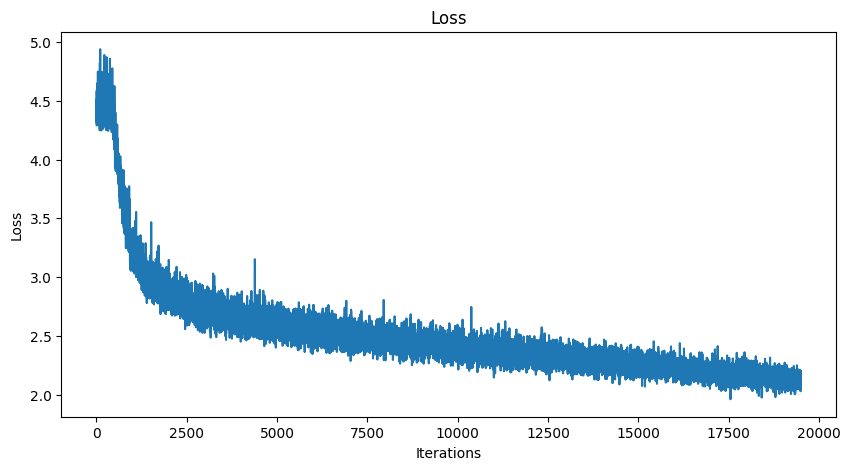

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(loss_tolist)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

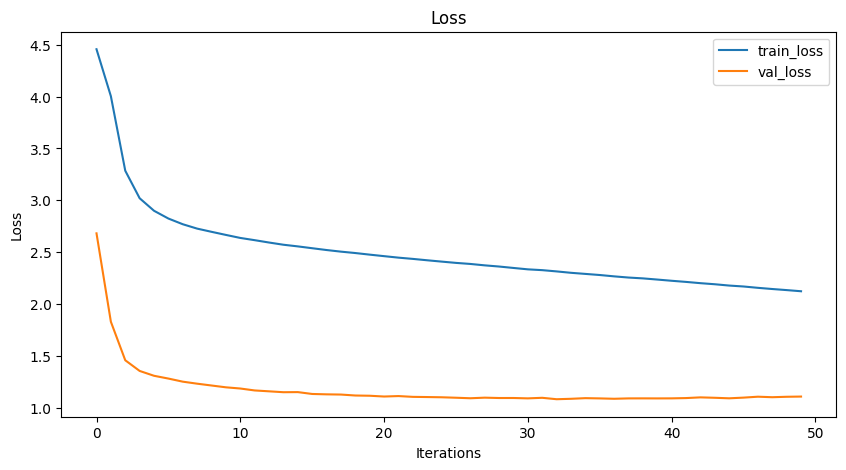

In [64]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label = 'train_loss')
plt.plot(val_loss_list, label = 'val_loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

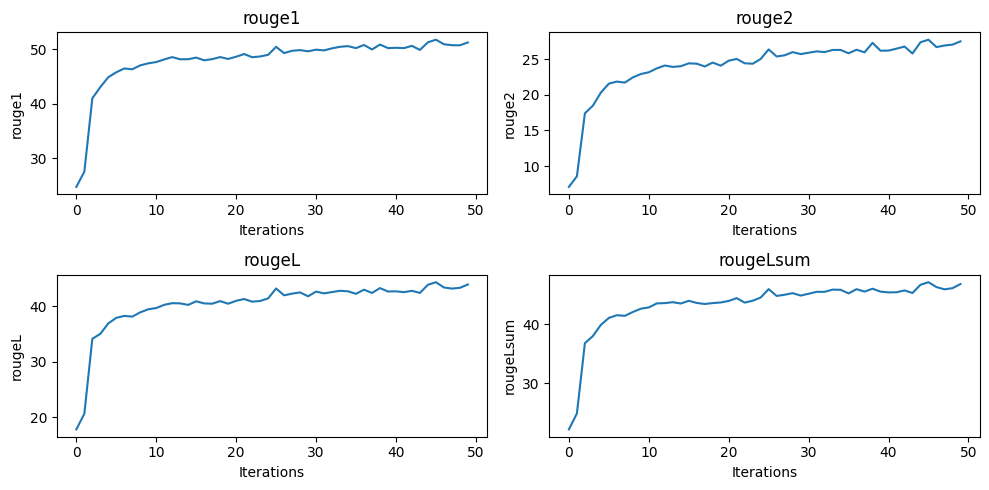

In [65]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.plot(rouge1_list)
plt.xlabel('Iterations')
plt.ylabel('rouge1')
plt.title('rouge1')

plt.subplot(2, 2, 2)
plt.plot(rouge2_list)
plt.xlabel('Iterations')
plt.ylabel('rouge2')
plt.title('rouge2')

plt.subplot(2, 2, 3)
plt.plot(rougeL_list)
plt.xlabel('Iterations')
plt.ylabel('rougeL')
plt.title('rougeL')

plt.subplot(2, 2, 4)
plt.plot(rougeLsum_list)
plt.xlabel('Iterations')
plt.ylabel('rougeLsum')
plt.title('rougeLsum')

plt.tight_layout()
plt.show()

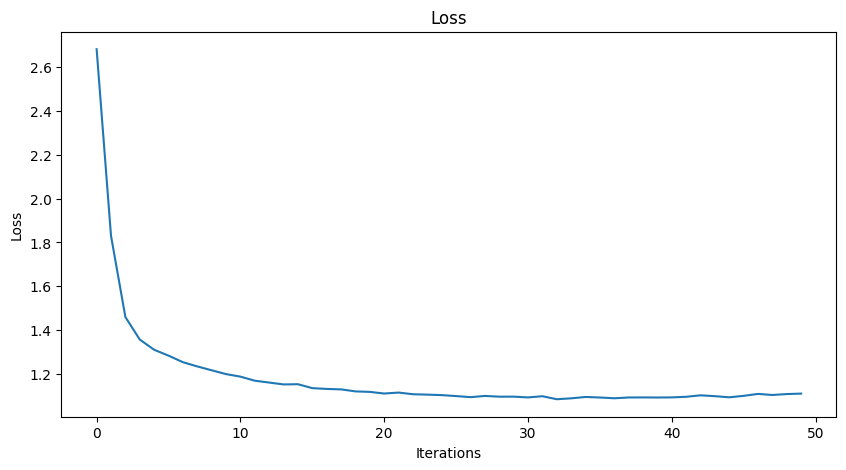

In [66]:
plt.figure(figsize=(10, 5))
# plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()